In [1]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')

from utils_libs import *
from utils_data_prep import *

from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import chisqprob

from numpy import prod
import seaborn as sns

# statiscal models
import statsmodels as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic


/home/guo/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# --- Load pre-processed order book data ---

all_dta_minu = np.load("../dataset/bitcoin/dta_minu.dat")
all_loc_hour = np.load("../dataset/bitcoin/loc_hour.dat")
print len(all_dta_minu), len(all_loc_hour)

# --- Load order book data files ---

# all_dta_minu,all_loc_hour = load_raw_order_book_files('../dataset/bitcoin/order_book/*.csv', True)

539157 10641


In [3]:
# --- calculate price, return and volatility ---

price_minu, req_minu = cal_price_req_minu(all_dta_minu)

print np.shape(price_minu), np.shape(req_minu)

pvol_hour = cal_price_volatility_hour( all_loc_hour, price_minu )
return_minu, rvol_hour = cal_return_volatility_hour( all_loc_hour, price_minu, 'per' )

print len(price_minu),len(return_minu), len(pvol_hour), len(rvol_hour)

(539157,) (539157, 2)
539157 528516 10641 10641


In [6]:
# --- extract features w.r.t. minute ---

features_minu = [] 
# ask mean price, mean amount, var price, var amount, 
# bid mean price, mean amount, var price, var amount,
# ask skew price, skew amount
# bid skew price, skew amount, 
# ask request, bid request

for i in range( len(all_dta_minu) ):
    tmp_a = all_dta_minu[i][0]
    tmp_b = all_dta_minu[i][1]
#   shape abov e: # by [price, amount]
    
#   mle_norm_2d() replaced by Nino func  
    tmpft = mle_norm_2d(tmp_a)
    tmp = tmpft[0] + tmpft[1]
    
#   mle_norm_2d() replaced by Nino func  
    tmpft = mle_norm_2d(tmp_b)
    tmp += tmpft[0]
    tmp += tmpft[1]
    
    #   skewness feature
    tmp += skewness(tmp_a)
    tmp += skewness(tmp_b)
    
    features_minu.append( tmp )
    
    # amount of requests
    tmp += [len(all_dta_minu[i][0]), len(all_dta_minu[i][1])] 
    
#     if len(all_dta_minu[i][0]) ==0 or len(all_dta_minu[i][1])==0:
#             print len(all_dta_minu[i][0]), len(all_dta_minu[i][1])
            
#  # of miniutes by # features
features_minu = np.reshape( features_minu, (len(features_minu), -1) )

print np.shape( np.asarray(features_minu) )

(539157, 14)


In [ ]:
# Correlation Matrix

import matplotlib.pyplot as plt
import pandas
import numpy
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pandas.read_csv(url, names=names)
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [ ]:
# Distribution of mininute observations 
hour_inter = np.diff(all_loc_hour)
fig, ax = plt.subplots()

fig.set_size_inches( 5,5 )
bins = [i for i in range(0,61,5)]
tmp = ax.hist(hour_inter, bins, histtype='bar',  \
        label=['Normed hist'])
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('# of minute obs in hour', fontsize=13)
ax.set_xlim(0,60)
sns.set_style('whitegrid')
sns.kdeplot(np.array(hour_inter), bw=0.5, label='Density')
ax.legend()


# target variable distribution
fig, ax = plt.subplots()
fig.set_size_inches( 5,5 )
ax.hist(rvol_hour, histtype='bar',  \
        label=['Normed hist'], bins = 30)
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('Return Volatility', fontsize=13)
ax.set_xlim(0,3)

sns.set_style('whitegrid')
# sns.kdeplot(np.array(rvol_hour), bw=0.5, label='Density')
ax.legend()


fig, ax1 = plt.subplots()
fig.set_size_inches( 5,5 )
ax1.hist(log( [i+1e-5 for i in rvol_hour] ), histtype='bar',    \
        label=['Normed hist'], bins =30)
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax1.set_xlabel('Log Return Volatility', fontsize=13)
# ax1.set_xlim(0,5)
sns.set_style('whitegrid')
# sns.kdeplot(np.array(rvol_hour), bw=0.5, label='Density')
ax1.legend()

# QQ plot 
# import numpy as np 
# import pylab 
# import scipy.stats as stats

# measurements = np.random.normal(loc = 20, scale = 5, size=100)   
# stats.probplot(measurements, dist="norm", plot=pylab)
# pylab.show()

In [ ]:
# Auto-correlaiton and Partial autocorrelation plot 

lag_corr  = acf(  rvol_hour, nlags = 48, alpha=0.05 )  
lag_pcorr = pacf( rvol_hour, nlags = 48, alpha=0.05  ) 

lag_corr = [ [i[0],i[1][0], i[1][1]] for i in zip(list(lag_corr[0]), list(lag_corr[1])) ]
lag_corr = np.asarray(lag_corr)

lag_pcorr = [ [i[0],i[1][0], i[1][1]] for i in zip(list(lag_pcorr[0]), list(lag_pcorr[1])) ]
lag_pcorr = np.asarray(lag_pcorr)


fig, ax = plt.subplots()
ax.plot(lag_corr,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')

fig, ax = plt.subplots()
ax.plot(lag_pcorr,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'r')
# ax.plot(lag_pcorr, marker='o', linestyle='--', label = 'Partial auto-correlation', color ='r')
# ax.legend()

# [1,3,4,16,18]
# [i for i in enumerate(lag_pcorr)]

In [6]:
# ARMA order check 

def ts_stationarize_diff( ts ):
    cur_ts = ts
    
    p_val = sm.tsa.stattools.adfuller(cur_ts,\
                                      regression='c', \
                                      maxlag=None, store=False)[1]
    diff_cnt = 0 
    while p_val > 0.01:
                
        pre_ts = cur_ts[1:]
        post_ts = cur_ts[:-1]
        
        diff_cnt += 1
        tmplen= len(pre_ts)
        cur_ts = [ pre_ts[i] - post_ts[i] for i in range(tmplen) ] 
        p_val = sm.tsa.stattools.adfuller(cur_ts,\
                                          regression='c', \
                                          maxlag=None, store=False)[1]
    return diff_cnt, p_val, cur_ts

def auto_arma(ar_range, x):
    
    aic_ar_ma = []
    for i in ar_range :
            
            model = sm.tsa.arima_model.ARIMA(x, order=(i, 0, 0))
            results = model.fit(disp= 1, trend = 'c', transparams=False, method="mle", verbose= False)
#             {‘css-mle’,’mle’,’css’}
            
            aic_ar_ma.append( [i, results.aic] )
            
            #print 'lag', i, results.aic, results.bic, results.pvalues
            
    return min(aic_ar_ma, key= lambda x: x[1])


def statistical_test(x):
    
    print 'Adfuller test:\n', sm.tsa.stattools.adfuller(x, regression='c', maxlag=None, store=False)
    print 'KPSS test:\n', sm.tsa.stattools.kpss(np.asarray(x),\
                                            regression='c', \
                                    lags=None, store=False)


In [7]:
# basic statistics property tests 

print statistical_test(rvol_hour)
# [1,3,4,16,18]

# Your data might have some level shift (the first half of the sample does not have quite the same level as 
# the second half) and perhaps some heteroskedasticity 

'''
# autoregressive order dynamics
order_seq = []
for i in range(1,9):
    order_seq.append(auto_arma([1,3,4,16,18], rvol_hour[(i-1)*1000 : i*1000]))

print order_seq

[[16, -5140.101292599884], [18, -2146.9425872982283], [16, -3005.067833567963],\
 [16, -2750.9339658705867], [18, -2075.317251929653],\
 [3, -2435.8597446882004], [18, -344.6574447281487], [4, -492.70567069939943]]

# test on a chosen lag 
model = sm.tsa.arima_model.ARIMA(rvol_hour[:1000], order=(16, 0, 2))
results = model.fit(disp= 1, trend = 'c', transparams=False, method="mle")
'''

Adfuller test:
(-7.8621765124119216, 5.2485701562466376e-12, 33, 10607, {'5%': -2.8618125275314648, '1%': -3.4309666572306825, '10%': -2.5669150612637988}, -18403.479306481844)
KPSS test:
(1.6125401765073739, 0.01, 39, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347})
None


'\n# autoregressive order dynamics\norder_seq = []\nfor i in range(1,9):\n    order_seq.append(auto_arma([1,3,4,16,18], rvol_hour[(i-1)*1000 : i*1000]))\n\nprint order_seq\n\n[[16, -5140.101292599884], [18, -2146.9425872982283], [16, -3005.067833567963], [16, -2750.9339658705867], [18, -2075.317251929653], [3, -2435.8597446882004], [18, -344.6574447281487], [4, -492.70567069939943]]\n\n# test on a chosen lag \nmodel = sm.tsa.arima_model.ARIMA(rvol_hour[:1000], order=(16, 0, 2))\nresults = model.fit(disp= 1, trend = \'c\', transparams=False, method="mle")\n'

In [ ]:
roll_mean = pd.rolling_mean(results.resid, 50, min_periods=None, freq=None, center=True)  
roll_var = pd.rolling_var(results.resid, 50, min_periods=None, freq=None, center=True)  

fig, ax  = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot(roll_mean,  label = 'Rolling mean of Residuals' )
ax.legend()

fig1, ax1  = plt.subplots()
ax1.plot(roll_var,  label = 'Rolling variance of Residuals' )
ax1.legend()

In [ ]:
# print results.pvalues
fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )

ax.plot(results.resid,  label='Residuals over time' )
ax.legend()

fig1, ax1 = plt.subplots()
ax1.hist(results.resid, histtype='bar', label='Residual distribution')
ax1.legend()

# Ljung–Box test on residuals to test no auto-correlation
print sm.stats.diagnostic.acorr_ljungbox(results.resid, lags=None, boxpierce=False)[1]

# Normality test
print sp.stats.mstats.normaltest(results.resid)
# ft += [tmp.pvalue, tmp.statistic]

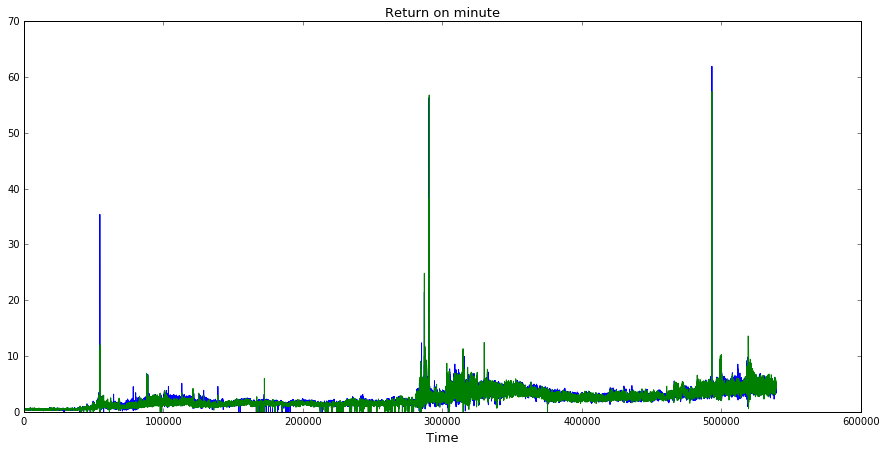

In [36]:
tmp = [[i[2], i[6]] for i in features_minu] 

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( tmp )
ax.set_title('Return on minute', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

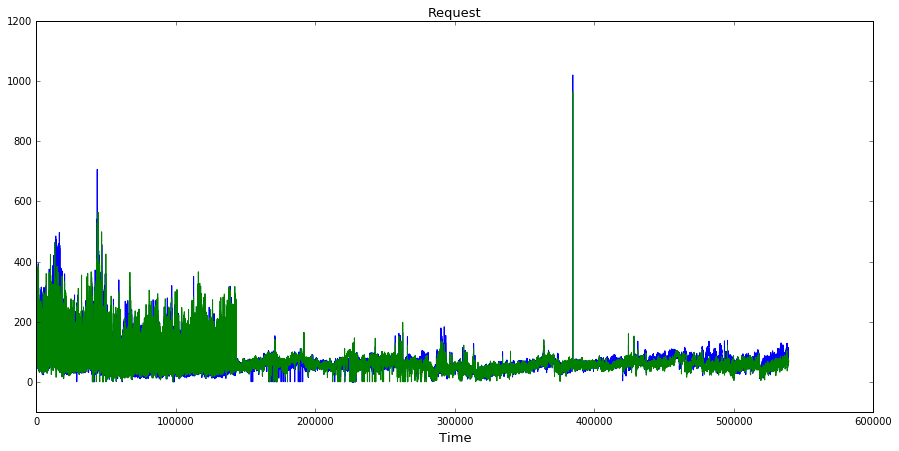

In [46]:
# request
tmp = [[i[12], i[13]] for i in features_minu] 

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( tmp )
ax.set_title('Request', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
ax.set_ylim(-100, 1200)
plt.legend()

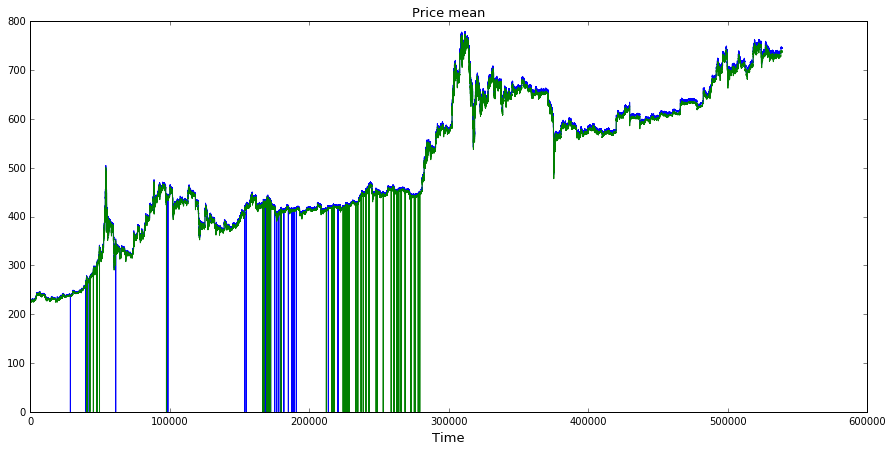

In [44]:
# ask mean price, mean amount, var price, var amount, 
# bid mean price, mean amount, var price, var amount,
# ask skew price, skew amount
# bid skew price, skew amount, 
# ask request, bid request

tmp = [[i[0], i[4]] for i in features_minu] 

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( tmp )
ax.set_title('Price mean', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

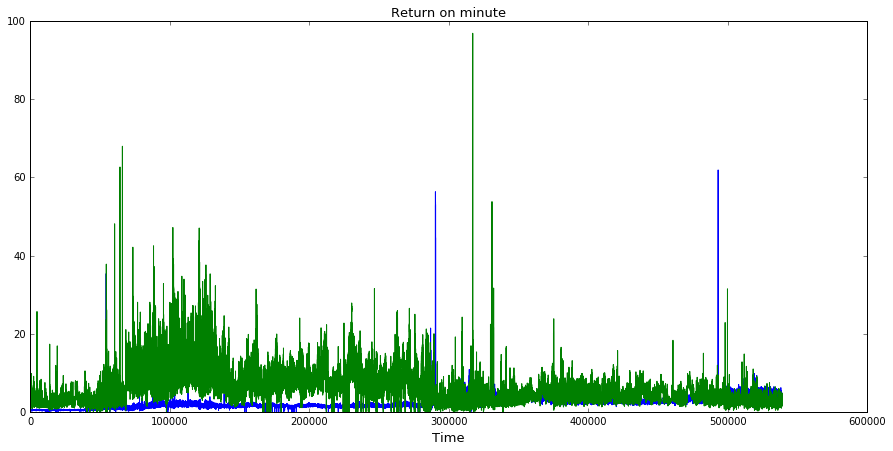

In [33]:
tmp = [[i[2], i[5]] for i in features_minu] 

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( tmp )
ax.set_title('Return on minute', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

5716


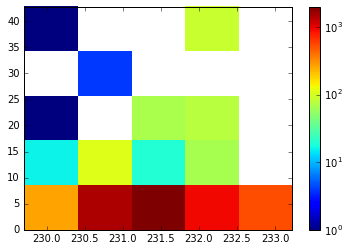

In [193]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

x=[]
y=[]
for i in range(60):
    tmpx = [j[0] for j in all_dta_minu[i][0]]
    tmpy = [j[1] for j in all_dta_minu[i][0]]
#     print type(tmpx), len(tmpy)
    x = x + tmpx
    y = y + tmpy

print len(x)
plt.hist2d(x, y, bins=5, norm=LogNorm())
plt.colorbar()
plt.show()


3696


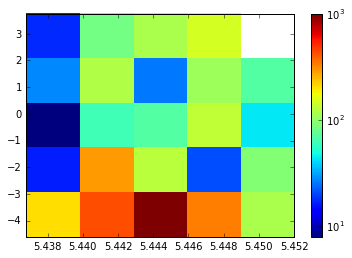

In [190]:
x=[]
y=[]
for i in range(40):
    tmpx = [ log(j[0]+1e-5) for j in all_dta_minu[i][0]]
    tmpy = [ log(j[1]+1e-5) for j in all_dta_minu[i][0]]
#     print type(tmpx), len(tmpy)
    x = x + tmpx
    y = y + tmpy

print len(x)
plt.hist2d(x, y, bins=5, norm=LogNorm())
plt.colorbar()
plt.show()

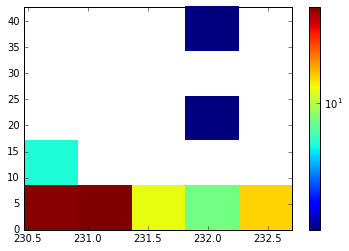

In [194]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

# normal distribution center at x=0 and y=5

x = [i[0] for i in all_dta_minu[10][0]]
y = [i[1] for i in all_dta_minu[10][0]]

plt.hist2d(x, y, bins=5, norm=LogNorm())
plt.colorbar()
plt.show()

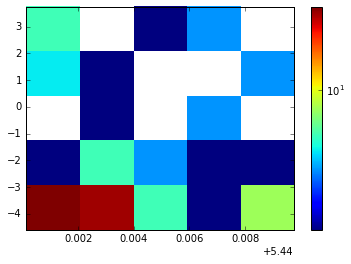

In [195]:
x = [log(i[0]+1e-5) for i in all_dta_minu[10][0]]
y = [log(i[1]+1e-5) for i in all_dta_minu[10][0]]

plt.hist2d(x, y, bins=5, norm=LogNorm())
plt.colorbar()
plt.show()

In [43]:
# --- test of extracted features w.r.t. minute ---

test_ask = [] 
test_bid = []
for i in range( len(all_dta_minu) ):
    tmp_a = all_dta_minu[i][0]
    tmp_b = all_dta_minu[i][1]
#   shape abov e: # by [price, amount]
    
#     mle_norm_2d  map_norm_2d
    test_ask.append( map_norm_2d(tmp_a) )
    test_bid.append( map_norm_2d(tmp_b) )

In [ ]:
# --- likelihood evaluation ---
from scipy.stats import multivariate_normal

n_sample = 100
tmpidx = range(len(all_dta_minu))
np.random.shuffle(tmpidx)
sample_dta_minu = all_dta_minu[tmpidx[:n_sample]]

for i in sample_dta_minu:
    tmpa = i[0]
    tmpb = i[1]
    
    tmp_para  = map_norm_2d(tmpa)
    loglk_min = loglk_norm( tmpa, tmp_para[0], tmp_para[1] )
    print tmp_para[1][2]
#     tmp_rv = sp.stats.norm( tmp_para[0][0], tmp_para[1][0])
#     print sp.stats.kstest( [i[0] for i in tmpa] ,tmp_rv.cdf )
    
#     tmp_rv = sp.stats.norm( tmp_para[0][1], tmp_para[1][1])
#     print sp.stats.kstest( [i[1] for i in tmpa] ,tmp_rv.cdf )

#     tmp_para = map_norm_2d(tmpa)
#     print sum(loglk_norm( tmpa, tmp_para[0], tmp_para[1] ))
    
    tmplog = [[log(i[0]+1e-07), log(i[1]+1e-07)] for i in tmpa]
    tmp_para  = mle_norm_2d( tmplog )
    print tmp_para[1][2]
    
#     loglk_max = loglk_norm( tmplog, tmp_para[0], tmp_para[1] )
    
#     tmp_rv = sp.stats.norm( tmp_para[0][0], tmp_para[1][0] )
#     print sp.stats.kstest( [i[0] for i in tmplog] ,tmp_rv.cdf )
    
#     tmp_rv = sp.stats.lognorm( tmp_para[0][1], tmp_para[1][1] )
#     print sp.stats.kstest( [i[1] for i in tmplog] ,tmp_rv.cdf )

#     print loglk_max,loglk_min, likelihood_ratio_test(loglk_min, loglk_max, 1)


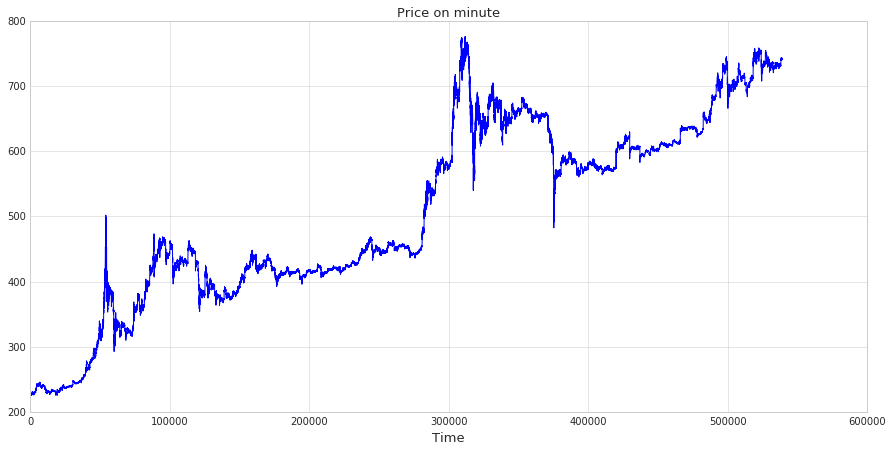

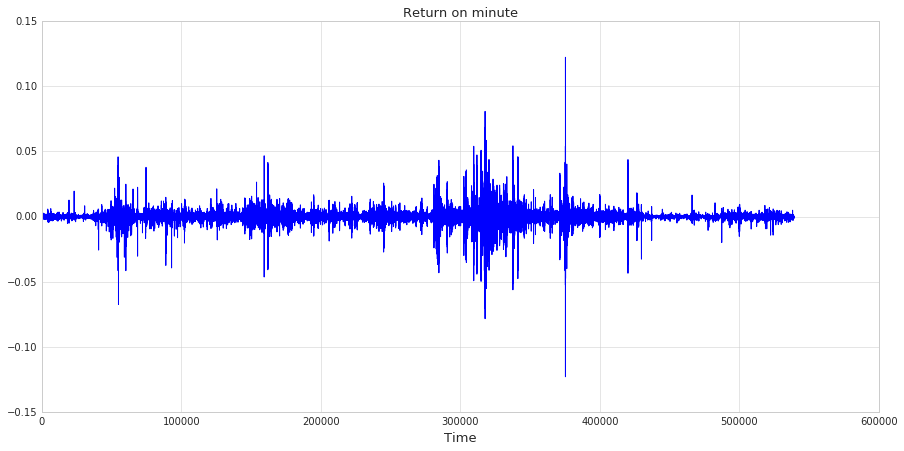

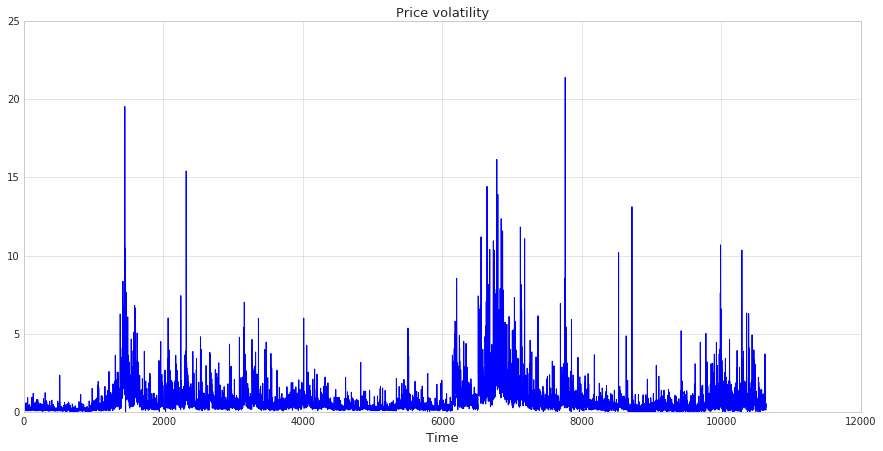

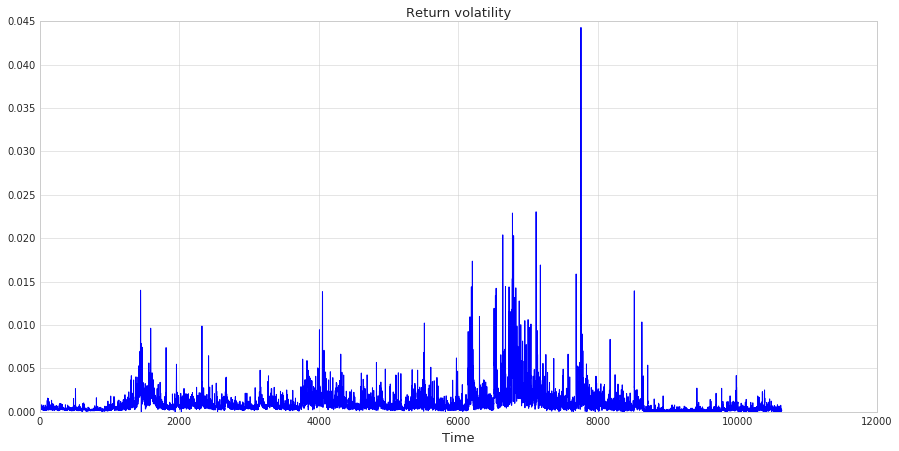

In [107]:
fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( price_minu )
ax.set_xlabel('Time', fontsize=13)
ax.set_title('Price on minute', fontsize=13)

plt.legend()

diff = []
for i in range(1, len(price_minu)):
    diff.append( log(price_minu[i]*1.0/price_minu[i-1]) )
    
fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( diff )
ax.set_title('Return on minute', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( pvol_hour )
ax.set_title('Price volatility', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( rvol_hour )
ax.set_title('Return volatility', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

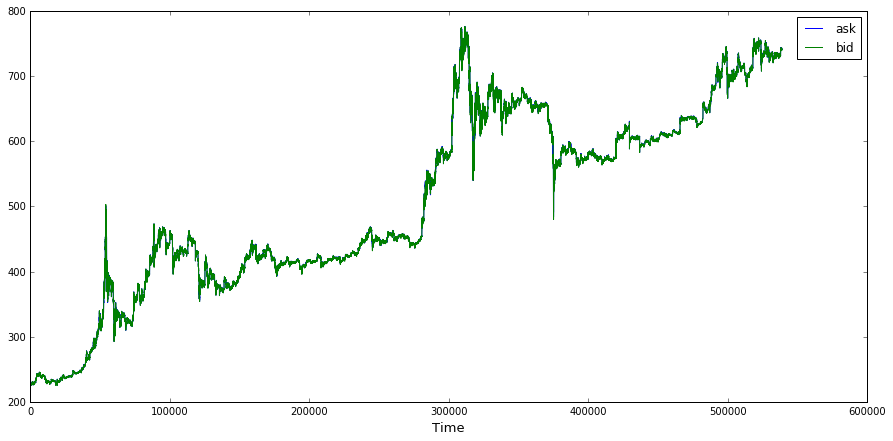

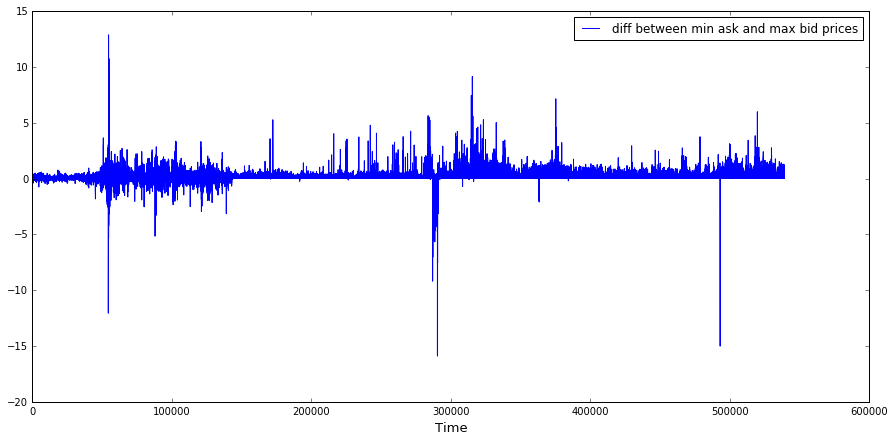

In [9]:
# --- test of extracted features w.r.t. minute ---

test_ask = [] 
test_bid = []
test_diff= []
for i in range( len(all_dta_minu) ):
    tmp_a = [ j[0] for j in all_dta_minu[i][0] ]
    tmp_b = [ j[0] for j in all_dta_minu[i][1] ]
    
    if tmp_a and tmp_b:
        test_ask.append( min(tmp_a) )
        test_bid.append( max(tmp_b) )
        test_diff.append( min(tmp_a)-max(tmp_b) )

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( test_ask , label = 'ask' )
ax.plot( test_bid , label = 'bid' )
ax.set_xlabel('Time', fontsize=13)
plt.legend()

fig1, ax1 = plt.subplots() 
fig1.set_size_inches((15,7))
ax1.plot( test_diff , label = 'diff between min ask and max bid prices' )
ax1.set_xlabel('Time', fontsize=13)
plt.legend()


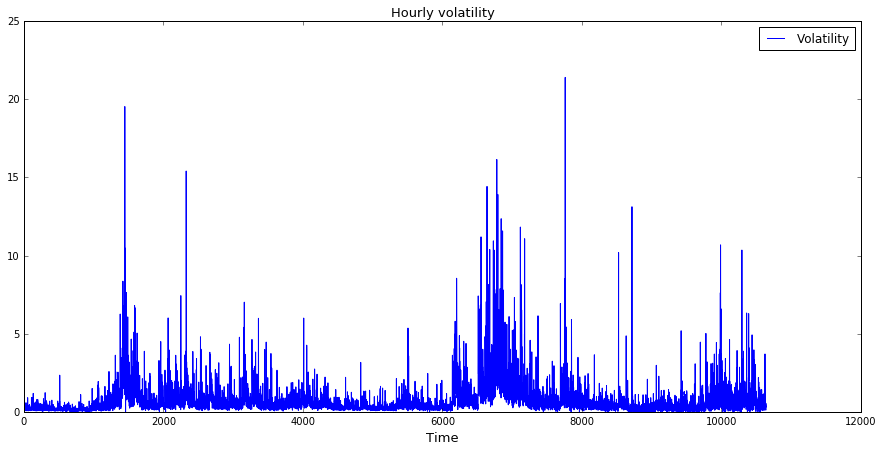

In [29]:
fig1, ax1 = plt.subplots() 
fig1.set_size_inches((15,7))
ax1.plot( pvol_hour , label = 'Volatility' )
ax1.set_title('Hourly volatility', fontsize=13)
# ax1.set_ylim(0,2)
ax1.set_xlabel('Time', fontsize=13)
plt.legend()


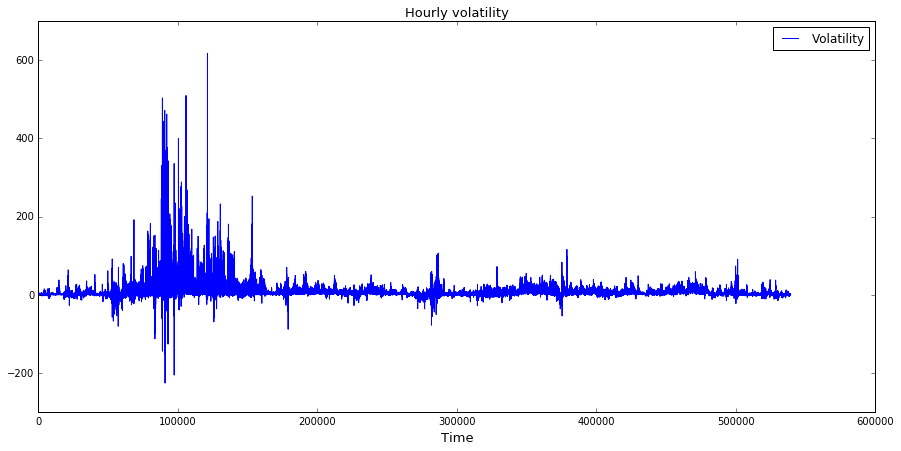

In [126]:
# Log-normal

fig1, ax1 = plt.subplots() 
fig1.set_size_inches((15,7))
ax1.plot( [i[4] for i in features_minu] , label = 'Volatility' )
ax1.set_title('Hourly volatility', fontsize=13)
# ax1.set_ylim(0,2)
ax1.set_xlabel('Time', fontsize=13)
plt.legend()

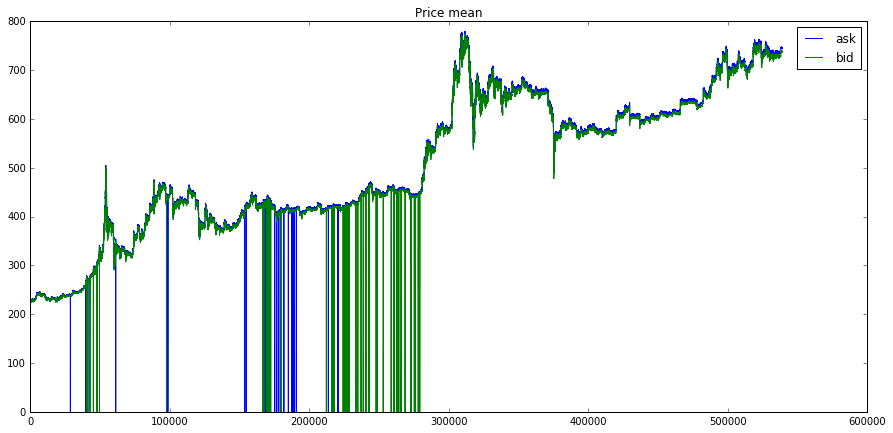

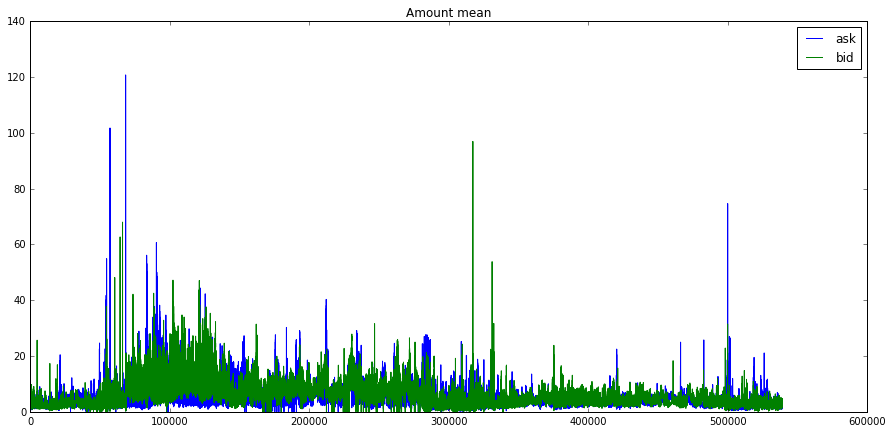

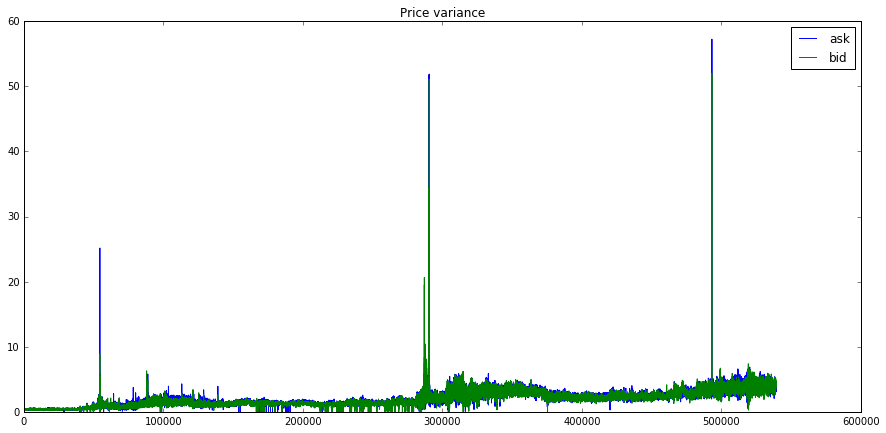

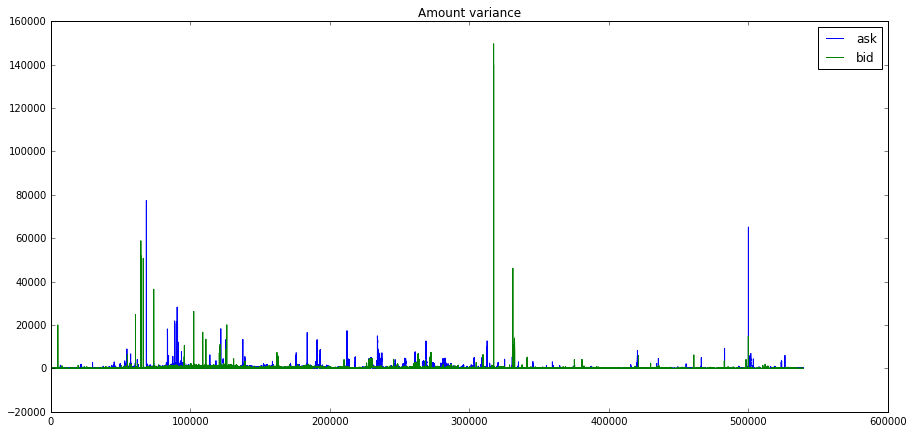

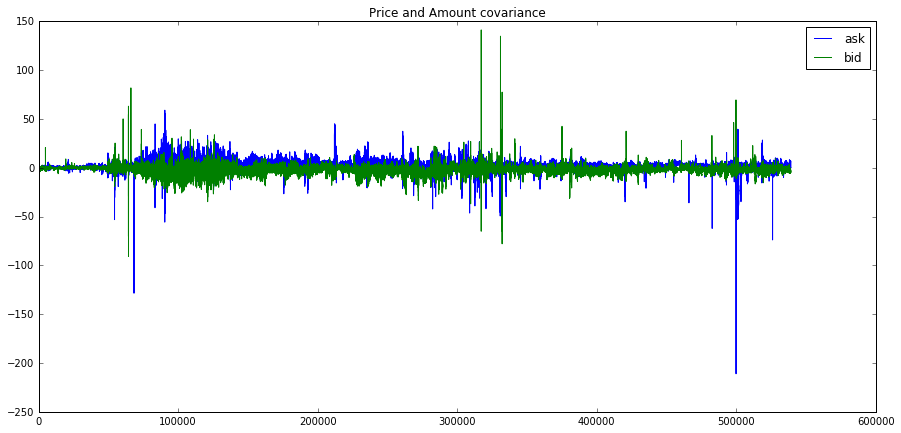

In [52]:
# MAP
plot_features( test_ask, test_bid )

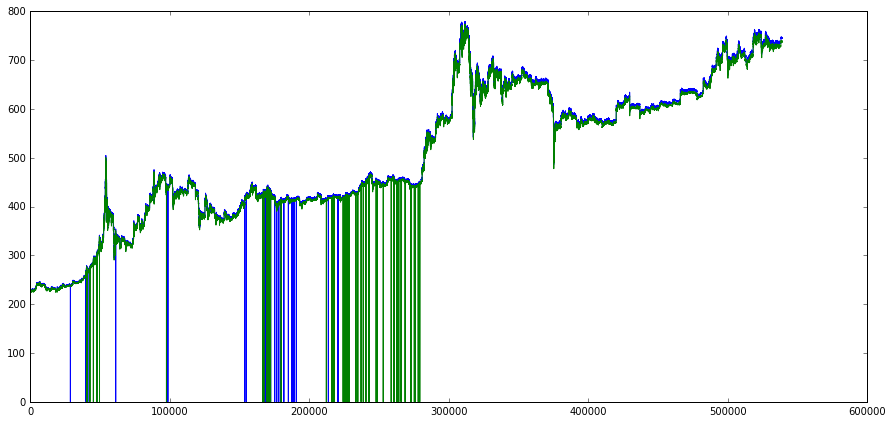

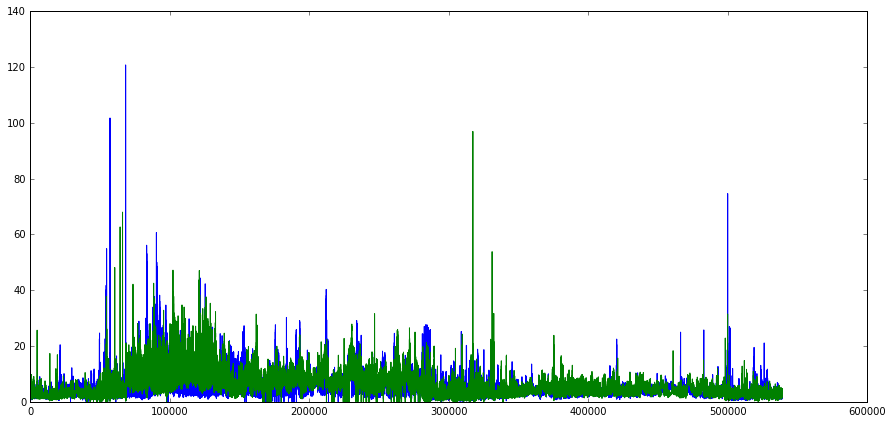

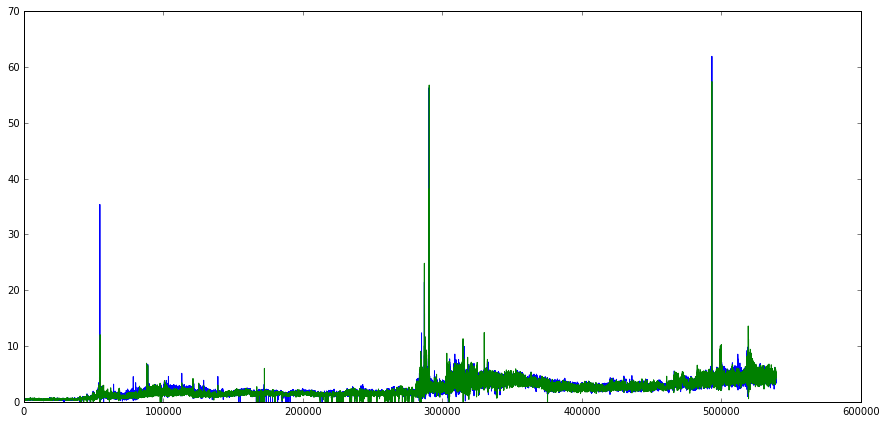

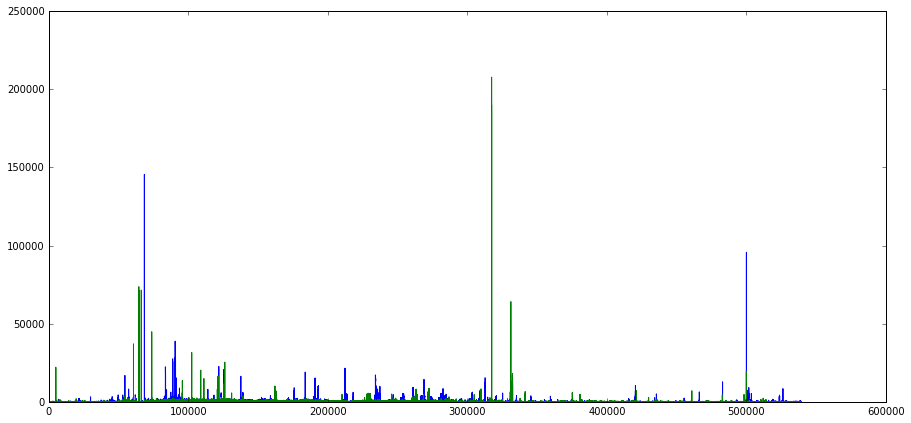

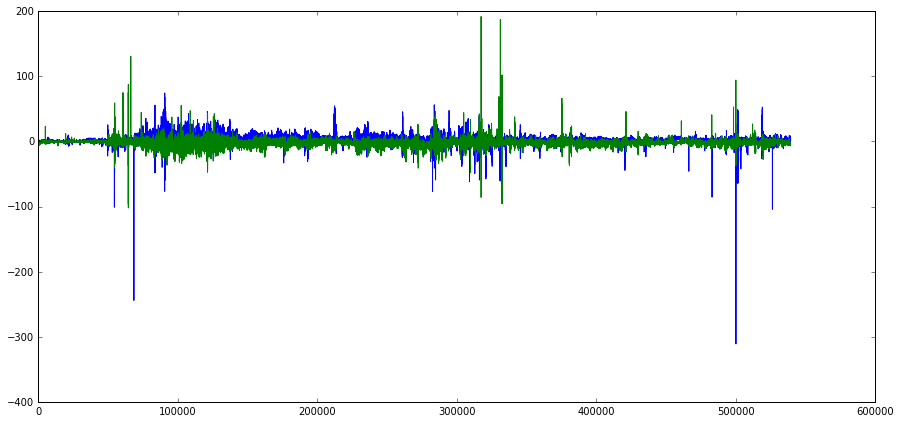

In [22]:
# MLE
# mean price, amount, covariance
plot_features( test_ask, test_bid )

[380.0, 380.5, 381.0, 381.5, 382.0, 382.5, 383.0, 383.5, 384.0, 384.5, 385.0, 385.5, 386.0, 386.5, 387.0, 387.5, 388.0, 388.5, 389.0, 389.5, 390.0, 390.5, 391.0, 391.5, 392.0, 392.5, 393.0, 393.5, 394.0, 394.5, 395.0, 395.5, 396.0, 396.5, 397.0, 397.5, 398.0, 398.5, 399.0, 399.5, 400.0, 400.5]


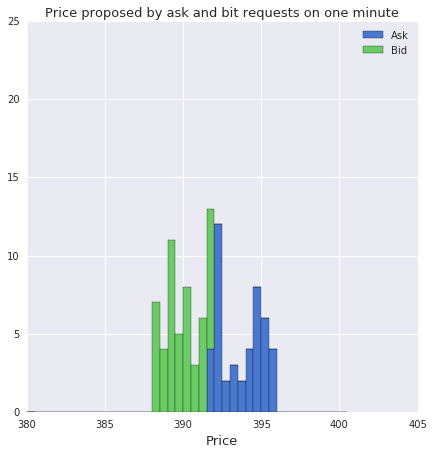

In [29]:
# ----- figure plot -----

import seaborn as sns
sns.set(style="darkgrid", palette="muted")

# --- histogram --- 
fig, ax = plt.subplots()
# ax0, ax1, ax2, ax3 = axes.flatten()
fig.set_size_inches( 7,7 )

# Make a multiple-histogram of data-sets with different length.
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
bin_edges = [ 380.0+ i*0.5 for i in range(42) ]
print bin_edges

ax.hist(price_minutes[0], bins = bin_edges, histtype='bar', rwidth = 1.0, stacked=True, \
        label=['Ask', 'Bid'])
ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('Price', fontsize=13)
ax.set_ylim(0,25)

ax.legend()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/hist_price.jpg', format='jpg',\
#             bbox_inches='tight')

# print bin_edges[1]
# # fig.tight_layout()
# plt.show()

# --- plot ---

fig = plt.figure()
fig.set_size_inches( figure_size )

ax = fig.add_subplot(111, xlabel='x', ylabel='y')

plt.plot( range(cnt),n_minu_hour )
#ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0)

# --- figure group ---

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, normed=1, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, normed=1, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')


# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()


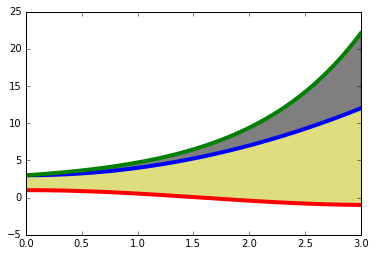

In [18]:
# plot filled region between lines 

import pylab as plt
import numpy as np

X  = np.linspace(0,3,200)
Y1 = X**2 + 3
Y2 = np.exp(X) + 2
Y3 = np.cos(X)

plt.plot(X,Y1,lw=4)
plt.plot(X,Y2,lw=4)
plt.plot(X,Y3,lw=4)

plt.fill_between(X, Y1,Y2,color='k',alpha=.5)
plt.fill_between(X, Y1,Y3,color='y',alpha=.5)

plt.show()

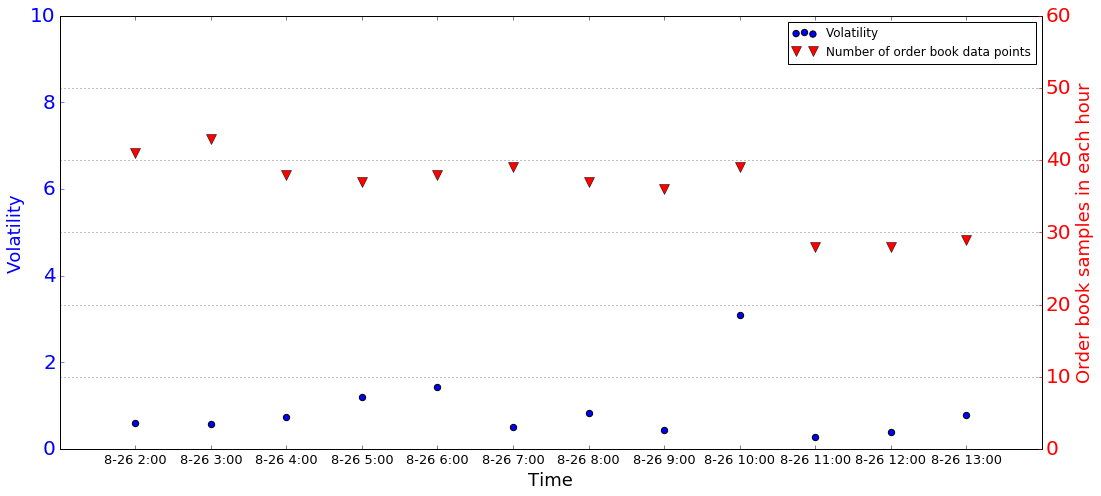

In [44]:
# import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

import matplotlib.ticker as ticker

labels = hour_tick

# sns.set(style="darkgrid", palette="muted")

figure_size = (15.4,7)
cnt = 12


fig, ax1 = plt.subplots() 
fig.set_size_inches( figure_size )

# ax1.scatter(vol_hour[:cnt])
lns1 = ax1.scatter(range(cnt), vol_hour[:cnt], s=40, label = 'Volatility' )
ax1.set_xlabel('Time: hour', fontsize= 18)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Volatility', color='b', fontsize=18)
ax1.set_ylim(0, 10)

ax1.tick_params('y', colors='b')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.tick_params(axis='x', which='both', labelsize=13)


ax2 = ax1.twinx()
lns2 = ax2.plot(range(cnt), n_minu_hour, 'rv', markersize=10, label = 'Number of order book data points' )
ax2.set_ylabel('Order book samples in each hour', color='r', fontsize=18)
ax2.tick_params('y', colors='r')
ax2.set_ylim(0, 60)
# ax2.legend(loc=0)

plt.xticks( range(cnt), hour_tick[:cnt] )
ax1.set_xlim(-1,12)

plt.tick_params(axis='both', which='both', labelsize=20)
# plt.tick_params(axis='y', which='minor', labelsize=20)


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0)



fig.tight_layout()
plt.grid(True)
plt.show()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/vola_samples.jpg', format='jpg',\
#             bbox_inches='tight')

[0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 20, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 35, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 55, 57]
[0, 1, 3, 4, 5, 7, 10, 11, 12, 13, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 51, 55, 56]


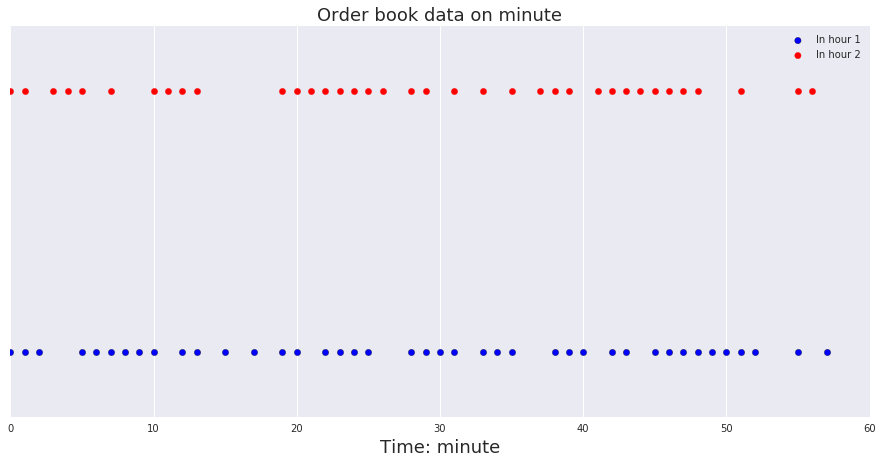

In [55]:
# minute ticks

sns.set(style="darkgrid", palette="muted")

minute_ticks = hour_unaggre[:3]

mtick1 = [i[4] for i in hour_unaggre[0]]
mtick2 = [i[4] for i in hour_unaggre[3]]
print mtick1
print mtick2

fig, ax1 = plt.subplots() 
fig.set_size_inches( figure_size )
plt.title('Order book data on minute', fontsize=18)

# ax1.scatter(vol_hour[:cnt])
ax1.scatter( mtick1, [1]*len(mtick1), s=40, label = 'In hour 1' )
ax1.set_xlabel( 'Time: minute', fontsize= 18 )
# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_ylabel('Volatility', color='b', fontsize=18)
ax1.set_xlim(0, 60)
ax1.scatter( mtick2, [1.2]*len(mtick2), s=40, color='r', label='In hour 2' )
plt.yticks([])
plt.legend()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/minu_ticks.jpg', format='jpg',\
#             bbox_inches='tight')


41 [36, 37, 38, 72, 74, 35, 38, 34, 35, 36, 34, 99, 32, 34, 69, 107, 35, 42, 40, 41, 42, 38, 42, 83, 41, 68, 37, 72, 36, 38, 36, 73, 41, 85, 38, 39, 74, 36, 83, 71, 108]
41 [47, 48, 46, 100, 113, 47, 48, 50, 47, 52, 51, 140, 48, 48, 98, 154, 51, 44, 46, 48, 48, 51, 51, 106, 53, 102, 47, 104, 52, 48, 51, 101, 51, 102, 43, 50, 108, 57, 110, 93, 125]


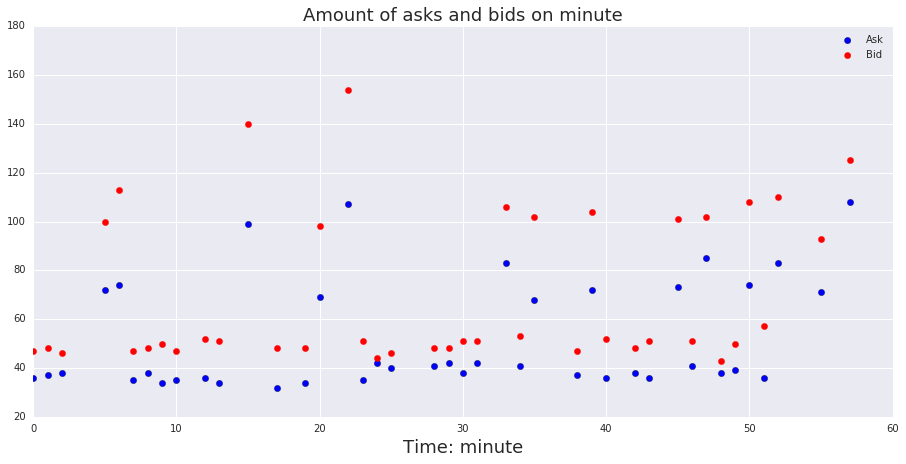

In [56]:
# number of samples in each minute

# number of ask in consecutive minutes
n_ask =  [len(i[0]) for i in hour_unaggre[0]]
print len(n_ask), n_ask 

# number of bid in consecutive minutes
n_bid = [len(i[2]) for i in hour_unaggre[0]]
print len(n_bid), n_bid

mtick = [i[4] for i in hour_unaggre[0]]


fig, ax1 = plt.subplots() 
fig.set_size_inches( figure_size )
plt.title('Amount of asks and bids on minute', fontsize=18)


# ax1.scatter(vol_hour[:cnt])
ax1.scatter( mtick, n_ask, s=40, label = 'Ask' )
ax1.set_xlabel( 'Time: minute', fontsize= 18 )
# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_ylabel('Volatility', color='b', fontsize=18)
ax1.set_xlim(0, 60)
ax1.scatter( mtick, n_bid, s=40, color='r', label='Bid' )
# plt.yticks([])
plt.legend()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/minu_ask_bid.jpg', format='jpg',\
#             bbox_inches='tight')


In [52]:
# irregular time intervals in miniutes 
for i in range(10):
    tmp_date = datetime.datetime.fromtimestamp(uni_ts[i]/1000.0)
    print tmp_date,tmp_date.date()
    

In [ ]:
# extract features from multi-varaite time series 
# argu: multi_ts, [time stamps, number of ts]
# TO DO:position distribution
def feature_extraction_multi_ts( multi_ts, n_compo, var_max_order ):
    
    ft = []
    
#   Matrix factorization 
#   choose components as features

    model = NMF(n_components=n_compo, init='random', random_state=0)
    W = model.fit_transform(multi_ts)
    H = model.components_

    ft += list( H.flatten() )

#   VAR
#   order distribution 
#   weight distribution
#   position distribution

    num_ts = len(multi_ts[0])

    model =  VAR(multi_ts)
    lags = model.select_order(var_max_order, verbose= False).values()
    lags.remove(0)
    
    chosen_lag = min(lags)
        
    result = model.fit( chosen_lag )
    
    coefs = np.transpose(result.coefs, [1,2,0])

    for i in range(num_ts):
        tmpcoefs = coefs[i]
        ft+= list(np.mean(tmpcoefs,1))
        ft+= list(np.var(tmpcoefs,1))
        
    return ft

# extract features from univaraite time series 
def feature_extraction_uni_ts( ts, corre_order, peoridic_order ):

    ft = []
    
#   length independent
    ft += list(acf(ts)[0:corre_order])
    ft += list(pacf(ts)[0:corre_order])
    
    ft += [mean(ts), var(ts)]
    
#   This function tests the null hypothesis that 
#   a sample comes from a normal distribution. 
#   It is based on D’Agostino and Pearson’s 
#   test that combines skew and kurtosis to produce 
#   an omnibus test of normality.
    tmp = sp.stats.mstats.normaltest(ts)
    ft += [tmp.pvalue, tmp.statistic]
    
#   seasonality
    f, Pxx_den = signal.periodogram(ts)
    tmp = zip(f, Pxx_den)
    tmp = sorted(tmp, key =lambda x: x[1], reverse =True )
    ft += list(np.reshape(tmp[:peoridic_order], [-1,]) )
    
#   length dependent
#     roll_var  = pd.rolling_var(ts, 10, min_periods=None, 
#     freq=None, center=True)
#     roll_mean = pd.rolling_mean(ts, 10, min_periods=None, 
#     freq=None, center=True)
    
    return ft

# Mean
# Var
# ACF1
# Trend
# Linearity
# Curvature
# Season
# Peak
# Trough
# Entropy
# Lumpiness
# Spikiness
# Lshift
# Vchange
# Fspots
# Cpoints
# KLscore
# Change.idx Mean.
# Variance.
# First order of autocorrelation.
# Strength of trend.
# Strength of linearity.
# Strength of curvature
# Strength of seasonality.
# Strength of peaks.
# Strength of trough.
# Spectral entropy.
# Changing variance in remainder.
# Strength of spikiness
# Level shift using rolling window.
# Variance change.
# Flat spots using disretization.
# The number of crossing points.
# Kullback-Leibler score.
# Index of the maximum KL score.



In [ ]:
# backup code 

# argu: merged order book data
# return: hour idx - minute-idx, #a, #b, a price mean, a price var, a amount mean, a amount var, 
# b price mean, b price var, b amount mean, b amount var, w.r.t. minutes 
def data_format_byHour( df ):
    
    cnt = df.shape[0]
    dta = []

#   initialization
    pre_hour = datetime.datetime.fromtimestamp(df.iloc[0]['date']/1000.0).hour
    pre_minu = datetime.datetime.fromtimestamp(df.iloc[0]['date']/1000.0).minute
    
    dta.append([])
    
#   a price, a amount, b price, b amount
    dta_minu = [[],[],[],[]]
    
    tmp_dta = df.iloc[0][ ['type','price','amount'] ]
    if tmp_dta['type']=='a':
        dta_minu[0].append(tmp_dta['price'])
        dta_minu[1].append(tmp_dta['amount'])
                    
    else:
        dta_minu[2].append(tmp_dta['price'])
        dta_minu[3].append(tmp_dta['amount'])
                    
#   main loop to re-format data
    for i in range(1,cnt):
        
        tmp_date = datetime.datetime.fromtimestamp(df.iloc[i]['date']/1000.0)
        
        tmp_hour= tmp_date.hour
        tmp_minute= tmp_date.minute

        tmp_dta = df.iloc[i][ ['type','price','amount'] ]
        
        if tmp_hour!= pre_hour:
            
            dta.append([])              
            dta_minu = [[],[],[],[]]
            
            if tmp_dta[ 'type']=='a':
                dta_minu[0].append(tmp_dta['price'])
                dta_minu[1].append(tmp_dta['amount'])
                    
            else:
                dta_minu[2].append(tmp_dta['price'])
                dta_minu[3].append(tmp_dta['amount'])
                    
            pre_hour = tmp_hour    
            pre_minu = tmp_minute
            
        else:
            if tmp_minute != pre_minu:

#               hour idx - minute-idx, #a, #b, a price mean, a price var, a amount mean, a amount var, 
#               b price mean, b price var, b amount mean, b amount var, w.r.t. minutes
                
                dta[-1].append( [ len(dta_minu[0]),len(dta_minu[2]), \
                                  mean(dta_minu[0]), var(dta_minu[0]), mean(dta_minu[1]), var(dta_minu[1]),\
                                  mean(dta_minu[2]), var(dta_minu[2]), mean(dta_minu[3]), var(dta_minu[3]) ] )
                
                dta_minu = [[],[],[],[]]
                
                if tmp_dta['type']=='a':
                    dta_minu[0].append(tmp_dta['price'])
                    dta_minu[1].append(tmp_dta['amount'])
                    
                else:
                    dta_minu[2].append(tmp_dta['price'])
                    dta_minu[3].append(tmp_dta['amount'])
                    
                pre_minu = tmp_minute
                
            else:
                if tmp_dta['type']=='a':
                    dta_minu[0].append(tmp_dta['price'])
                    dta_minu[1].append(tmp_dta['amount'])
                    
                else:
                    dta_minu[2].append(tmp_dta['price'])
                    dta_minu[3].append(tmp_dta['amount'])
    
    return dta

def data_format_price_byMinute( df ):
    
    cnt = df.shape[0]
    dta = []

#   initialization
    pre_hour = datetime.datetime.fromtimestamp(df.iloc[0]['date']/1000.0).hour
    pre_minu = datetime.datetime.fromtimestamp(df.iloc[0]['date']/1000.0).minute
    
    dta.append([])
    
#   a price, a amount, b price, b amount
    dta_minu = [[],[],[],[]]
    
    tmp_dta = df.iloc[0][ ['type','price','amount'] ]
    if tmp_dta['type']=='a':
        dta_minu[0].append(tmp_dta['price'])
        dta_minu[1].append(tmp_dta['amount'])
                    
    else:
        dta_minu[2].append(tmp_dta['price'])
        dta_minu[3].append(tmp_dta['amount'])
                    
#   main loop to re-format data
    for i in range(1,cnt):
        
        tmp_date = datetime.datetime.fromtimestamp(df.iloc[i]['date']/1000.0)
        
        tmp_hour= tmp_date.hour
        tmp_minute= tmp_date.minute

        tmp_dta = df.iloc[i][ ['type','price','amount'] ]
        
        if tmp_hour!= pre_hour:
            
            dta.append([])              
            dta_minu = [[],[],[],[]]
            
            if tmp_dta[ 'type']=='a':
                dta_minu[0].append(tmp_dta['price'])
                dta_minu[1].append(tmp_dta['amount'])
                    
            else:
                dta_minu[2].append(tmp_dta['price'])
                dta_minu[3].append(tmp_dta['amount'])
                    
            pre_hour = tmp_hour    
            pre_minu = tmp_minute
            
        else:
            if tmp_minute != pre_minu:

#               hour idx - minute-idx, #a, #b, a price mean, a price var, a amount mean, a amount var, 
#               b price mean, b price var, b amount mean, b amount var, w.r.t. minutes
                
                dta[-1].append( (max(dta_minu[2]) + min(dta_minu[0]))/2.0 )
                
                dta_minu = [[],[],[],[]]
                
                if tmp_dta['type']=='a':
                    dta_minu[0].append(tmp_dta['price'])
                    dta_minu[1].append(tmp_dta['amount'])
                    
                else:
                    dta_minu[2].append(tmp_dta['price'])
                    dta_minu[3].append(tmp_dta['amount'])
                    
                pre_minu = tmp_minute
                
            else:
                if tmp_dta['type']=='a':
                    dta_minu[0].append(tmp_dta['price'])
                    dta_minu[1].append(tmp_dta['amount'])
                    
                else:
                    dta_minu[2].append(tmp_dta['price'])
                    dta_minu[3].append(tmp_dta['amount'])
    
    return dta

In [ ]:
def ks2d1s(x1,y1,quadvl):
    """Two-dimensional Kolmogorov-Smirnov test of one sample against a model. Given the x and
    y coordinates of n1 data points in arrays x1[0..n1-1] and y1[0..n1-1], and given a user-
    supplied function quadvl that exemplifies the model, this routine returns the two-dimensional
    K-S statistic as d1, and its p-value as prob, all as an array. Small values of prob show that
    the sample is significantly different from the model. Note that the test is slightly distribution-
    dependent, so prob is only an estimate.
    """
    d1=prob=0.0
    n1=len(x1)
    r1=dum=dumm=0.0
    ks = KSdist()
    for j in xrange(n1):
        [fa,fb,fc,fd] = quadct(x1[j],y1[j],x1,y1)
        [ga,gb,gc,gd] = quadvl(x1[j],y1[j])
        if(fa>ga): fa += 1.0/n1
        if(fb>gb): fb += 1.0/n1
        if(fc>gc): fc += 1.0/n1
        if(fd>gd): fd += 1.0/n1
        d1 = max(d1,abs(fa-ga))
        d1 = max(d1,abs(fb-gb))
        d1 = max(d1,abs(fc-gc))
        d1 = max(d1,abs(fd-gd))
    [r1,dum,dumm] = pearsn(x1,y1)
    sqen = math.sqrt(n1)
    rr=math.sqrt(1.0-r1*r1)
    prob = ks.qks(d1*sqen/(1.0+rr*(0.25-0.75/sqen)))
    
    return [d1,prob]

def quadct(x,y,xx,yy):
    """Given an origin (x,y), and an array of nn points with coordinates
    xx[0..nn-1] and yy[0..nn-1], count how many of them are in each
    quadrant around the origin, and return the normalized fractions.
    Quadrants are labeled alphabetically, a counterclockwise from the 
    upper right. Used by ks2d1s and ks2d2s.
    """
    na=nb=nc=nd=0
    nn = len(xx)
    for k in xrange(nn):
        if(yy[k]==y and xx[k]==x): continue
        if(yy[k]>y):
            if(xx[k]>x): na += 1
            else: nb += 1
        else:
            if(xx[k]>x): nd += 1
            else: nc += 1
    ff=1.0/nn
    return [ff*na,ff*nb,ff*nc,ff*nd]

def quadvl(x,y):
    """This is a sample of a user-supplied routine to be used with ks2d1s.
    In this case, the model distribution is uniform inside the square.
    """
    qa=min(2.0,max(0.0,1.0-x))
    qb=min(2.0,max(0.0,1.0-y))
    qc=min(2.0,max(0.0,x+1.0))
    qd=min(2.0,max(0.0,y+1.0))
    fa=0.25*qa*qb
    fb=0.25*qb*qc
    fc=0.25*qc*qd
    fd=0.25*qd*qa
    
    return [fa,fb,fc,fd]